In [11]:
import numpy as np
import pandas as pd

df = pd.read_pickle("Data/news_embeddings_finBertTone.pkl")
df

,Date,Article_title,Stock_symbol,Url,close,1d_open,1d_close,3d_close,Unnamed: 0,arima_prediction,3d_change,3d_direction,arima_3d_direction,close_normalized,pos_sentiment,neu_sentiment,neg_sentiment
0,2009-08-17,NaN,AAPL,NaN,22.798571,23.090000,23.428572,23.761429,NaN,NaN,2.907876,1,-1,-1.523714,NaN,NaN,NaN
1,2009-08-18,NaN,AAPL,NaN,23.428572,23.250000,23.514286,24.174286,NaN,NaN,3.975423,1,-1,-1.515338,NaN,NaN,NaN
2,2009-08-19,NaN,AAPL,NaN,23.514286,23.568571,23.761429,24.151428,NaN,NaN,2.473027,1,-1,-1.514198,NaN,NaN,NaN
3,2009-08-20,NaN,AAPL,NaN,23.761429,23.950001,24.174286,24.200001,NaN,NaN,1.043841,1,-1,-1.510912,NaN,NaN,NaN
4,2009-08-21,NaN,AAPL,NaN,24.174286,24.302856,24.151428,23.915714,NaN,NaN,-1.592990,-1,-1,-1.505423,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59066,2023-12-21,NaN,TSLA,NaN,254.500000,256.760010,252.539993,261.440002,NaN,NaN,1.822711,1,-1,-0.210817,NaN,NaN,NaN
59067,2023-12-22,NaN,TSLA,NaN,252.539993,254.490005,256.609985,253.179993,NaN,NaN,-0.514760,-1,-1,-0.219649,NaN,NaN,NaN
59068,2023-12-26,NaN,TSLA,NaN,256.609985,258.350006,261.440002,NaN,NaN,NaN,NaN,-1,-1,-0.201309,NaN,NaN,NaN
59069,2023-12-27,NaN,TSLA,NaN,261.440002,263.660004,253.179993,NaN,NaN,NaN,NaN,-1,-1,-0.179543,NaN,NaN,NaN


In [12]:
df["Stock_symbol"].unique()

array(['AAPL', 'ADBE', 'AMD', 'AMZN', 'BBK', 'GOOGL', 'GRMN', 'HPQ',
       'IBM', 'INTC', 'NFLX', 'NVDA', 'ORCL', 'TSLA'], dtype=object)

In [18]:
from sklearn.model_selection import train_test_split
import numpy as np

for stock in df["Stock_symbol"].unique():
    df_stock = df[df["Stock_symbol"] == stock]
    news_count = sum(df_stock['Article_title'].notna())
    if news_count < 1800:
        continue
    print(stock, news_count)
    
        
    

AAPL 374
ADBE 1787
AMD 196
AMZN 225
BBK 19
GOOGL 1035
GRMN 1575
HPQ 446
IBM 845
INTC 1844
NFLX 2245
NVDA 2483
ORCL 2180
TSLA 1470


In [22]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_percentage_error

# Define LSTM
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])

# Train
def train_lstm(model, train_loader, criterion, optimizer, epochs=20):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# prepare LSTM data
def create_sequences(data, target, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

#loop for each stock
window_size = 10
batch_size = 32

for stock in df["Stock_symbol"].unique():
    df_stock = df[df["Stock_symbol"] == stock]
    news_count = sum(df_stock['Article_title'].notna())
    
    if news_count < 1800:
        continue
    
    print(f"Processing {stock}, News Count: {news_count}")

    df_stock = df_stock.sort_values(by="Date").reset_index(drop=True)

    split_idx = int(len(df_stock) * 0.8)
    train_data, test_data = df_stock.iloc[:split_idx], df_stock.iloc[split_idx:]
 
    X_train, y_train = create_sequences(train_data["close"].values.reshape(-1, 1), train_data["3d_change"].values, window_size)
    X_test, y_test = create_sequences(test_data["close"].values.reshape(-1, 1), test_data["3d_change"].values, window_size)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)
    
    model = LSTMModel(input_size=1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    train_lstm(model, train_loader, criterion, optimizer)

    model.eval()
    with torch.no_grad():
        y_pred_lstm = model(X_test_tensor).numpy().flatten()

    true_values = test_data.iloc[window_size:]["3d_change"].values 
    arima_pred = test_data.iloc[window_size:]["arima_prediction"].values

    valid_indices = ~np.isnan(true_values) & ~np.isnan(arima_pred) & (true_values != 0)

    true_values_filtered = true_values[valid_indices]
    arima_pred_filtered = arima_pred[valid_indices]
    y_pred_lstm_filtered = y_pred_lstm[valid_indices]

    if len(true_values_filtered) > 0:
        mape_lstm_true = np.mean(np.abs((true_values_filtered - y_pred_lstm_filtered) / true_values_filtered)) * 100
        print(f"MAPE (LSTM vs True) for {stock}: {mape_lstm_true:.4f}%")
    else:
        print(f"Skipping MAPE (LSTM vs True) for {stock} due to insufficient valid data.")

    # Compute MAPE: ARIMA vs True
    if len(arima_pred_filtered) > 0:
        mape_arima_true = np.mean(np.abs((true_values_filtered - arima_pred_filtered) / true_values_filtered)) * 100
        print(f"MAPE (ARIMA vs True) for {stock}: {mape_arima_true:.4f}%")
    else:
        print(f"Skipping MAPE (ARIMA vs True) for {stock} due to insufficient valid data.")

    # Compute MAPE: LSTM vs ARIMA
    valid_indices_comparison = ~np.isnan(arima_pred) & ~np.isnan(y_pred_lstm) & (arima_pred != 0)
    arima_pred_filtered_comp = arima_pred[valid_indices_comparison]
    y_pred_lstm_filtered_comp = y_pred_lstm[valid_indices_comparison]

    if len(arima_pred_filtered_comp) > 0:
        mape_lstm_arima = np.mean(np.abs((arima_pred_filtered_comp - y_pred_lstm_filtered_comp) / arima_pred_filtered_comp)) * 100
        print(f"MAPE (LSTM vs ARIMA) for {stock}: {mape_lstm_arima:.4f}%")
    else:
        print(f"Skipping MAPE (LSTM vs ARIMA) for {stock} due to insufficient valid data.")



Processing INTC, News Count: 1844
Epoch 5/20, Loss: 8.5261
Epoch 10/20, Loss: 8.4711
Epoch 15/20, Loss: 8.4411
Epoch 20/20, Loss: 8.4420
MAPE (LSTM vs True) for INTC: 112.1116%
MAPE (ARIMA vs True) for INTC: 223.7873%
MAPE (LSTM vs ARIMA) for INTC: 103.0507%
Processing NFLX, News Count: 2245
Epoch 5/20, Loss: 28.7542
Epoch 10/20, Loss: 28.7162
Epoch 15/20, Loss: 28.8204
Epoch 20/20, Loss: 28.7530
MAPE (LSTM vs True) for NFLX: 130.5877%
MAPE (ARIMA vs True) for NFLX: 455.1711%
MAPE (LSTM vs ARIMA) for NFLX: 114.2939%
Processing NVDA, News Count: 2483
Epoch 5/20, Loss: 26.1908
Epoch 10/20, Loss: 26.1052
Epoch 15/20, Loss: 26.0978
Epoch 20/20, Loss: 25.8848
MAPE (LSTM vs True) for NVDA: 116.6089%
MAPE (ARIMA vs True) for NVDA: 787.8857%
MAPE (LSTM vs ARIMA) for NVDA: 97.0309%
Processing ORCL, News Count: 2180
Epoch 5/20, Loss: 9.4255
Epoch 10/20, Loss: 9.4016
Epoch 15/20, Loss: 9.4070
Epoch 20/20, Loss: 9.3796
MAPE (LSTM vs True) for ORCL: 100.8102%
MAPE (ARIMA vs True) for ORCL: 143.2080

Processing NFLX, News Count: 2245


C:\Users\Jerry\AppData\Local\Temp\ipykernel_72924\3357097938.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[feature_cols] = (train_data[feature_cols] - mean_std.loc["mean"]) / mean_std.loc["std"]
C:\Users\Jerry\AppData\Local\Temp\ipykernel_72924\3357097938.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature_cols] = (test_data[feature_cols] - mean_std.loc["mean"]) / mean_std.loc["std"]


Epoch 10/70, Loss: 3.2062
Epoch 20/70, Loss: 3.1518
Epoch 30/70, Loss: 3.1095
Epoch 40/70, Loss: 3.1006
Epoch 50/70, Loss: 3.0898
Epoch 60/70, Loss: 3.1031
Epoch 70/70, Loss: 3.0939
LSTM MAPE for NFLX: 209.88%
ARIMA MAPE for NFLX: 427.71%
LSTM Accuracy for NFLX: 0.4799
ARIMA Accuracy for NFLX: 0.5789


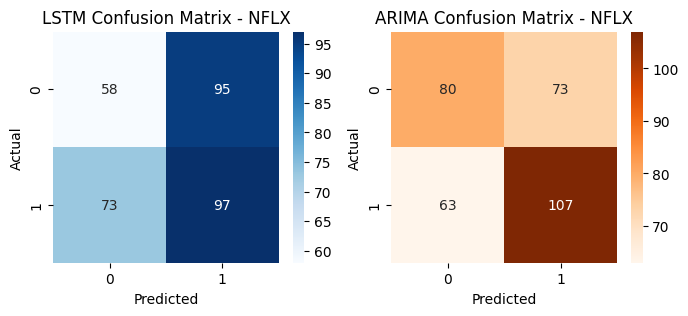

Processing NVDA, News Count: 2483


C:\Users\Jerry\AppData\Local\Temp\ipykernel_72924\3357097938.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[feature_cols] = (train_data[feature_cols] - mean_std.loc["mean"]) / mean_std.loc["std"]
C:\Users\Jerry\AppData\Local\Temp\ipykernel_72924\3357097938.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature_cols] = (test_data[feature_cols] - mean_std.loc["mean"]) / mean_std.loc["std"]


Epoch 10/70, Loss: 2.5531
Epoch 20/70, Loss: 2.4926
Epoch 30/70, Loss: 2.4811
Epoch 40/70, Loss: 2.5009
Epoch 50/70, Loss: 2.5139
Epoch 60/70, Loss: 2.5078
Epoch 70/70, Loss: 2.4757
LSTM MAPE for NVDA: 100.91%
ARIMA MAPE for NVDA: 189.51%
LSTM Accuracy for NVDA: 0.5362
ARIMA Accuracy for NVDA: 0.5792


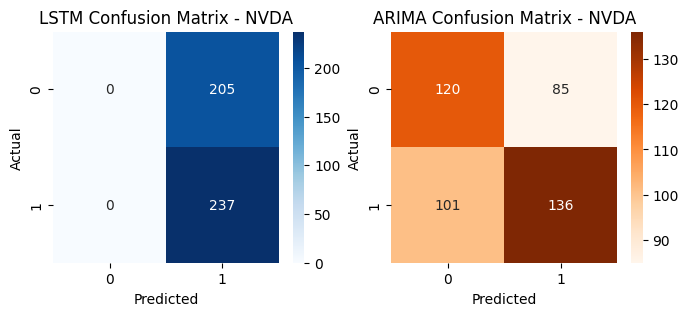

Processing ORCL, News Count: 2180


C:\Users\Jerry\AppData\Local\Temp\ipykernel_72924\3357097938.py:117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data[feature_cols] = (train_data[feature_cols] - mean_std.loc["mean"]) / mean_std.loc["std"]
C:\Users\Jerry\AppData\Local\Temp\ipykernel_72924\3357097938.py:118: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data[feature_cols] = (test_data[feature_cols] - mean_std.loc["mean"]) / mean_std.loc["std"]


Epoch 10/70, Loss: 1.3229
Epoch 20/70, Loss: 1.2031
Epoch 30/70, Loss: 1.1208
Epoch 40/70, Loss: 1.0518
Epoch 50/70, Loss: 1.0363
Epoch 60/70, Loss: 1.0105
Epoch 70/70, Loss: 0.9988
LSTM MAPE for ORCL: inf%
ARIMA MAPE for ORCL: inf%
LSTM Accuracy for ORCL: 0.4683
ARIMA Accuracy for ORCL: 0.5741


C:\Users\Jerry\AppData\Local\Temp\ipykernel_72924\3357097938.py:161: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


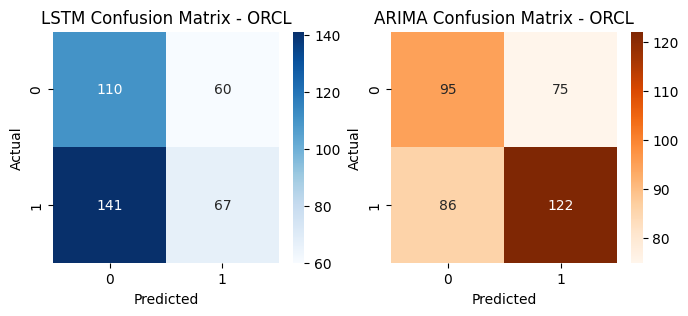

In [33]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, accuracy_score

# Define LSTM 
class LSTMModel(nn.Module):
    def __init__(self, input_size=4, hidden_size=64, num_layers=2, output_size=1):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        return self.fc(lstm_out[:, -1, :])  # Take last time step output

# Train
def train_lstm(model, train_loader, criterion, optimizer, epochs=120):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_batch)
            loss = criterion(y_pred, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# prepare data
def create_sequences(data, target, window_size=10):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(target[i + window_size])
    return np.array(X), np.array(y)

# Function to plot confusion matrices
def plot_confusion_matrices(y_true, y_pred_lstm, y_pred_arima, stock):
    fig, axes = plt.subplots(1, 2, figsize=(8, 3))

    # binary
    y_true_binary = (y_true > 0).astype(int)
    y_pred_lstm_binary = (y_pred_lstm > 0).astype(int)
    y_pred_arima_binary = (y_pred_arima > 0).astype(int)

    # LSTM Confusion Matrix
    cm_lstm = confusion_matrix(y_true_binary, y_pred_lstm_binary)
    sns.heatmap(cm_lstm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
    axes[0].set_title(f"LSTM Confusion Matrix - {stock}")
    axes[0].set_xlabel("Predicted")
    axes[0].set_ylabel("Actual")

    # ARIMA Confusion Matrix
    cm_arima = confusion_matrix(y_true_binary, y_pred_arima_binary)
    sns.heatmap(cm_arima, annot=True, fmt="d", cmap="Oranges", ax=axes[1])
    axes[1].set_title(f"ARIMA Confusion Matrix - {stock}")
    axes[1].set_xlabel("Predicted")
    axes[1].set_ylabel("Actual")

    plt.show()

window_size = 10  # Lookback window
batch_size = 32

for stock in df["Stock_symbol"].unique():
    df_stock = df[df["Stock_symbol"] == stock]
    news_count = sum(df_stock['Article_title'].notna())

    if news_count < 2000:
        continue

    print(f"Processing {stock}, News Count: {news_count}")

    # Sort by Date
    df_stock = df_stock.sort_values(by="Date").reset_index(drop=True)

    # Fill NaN sentiment with 0.33
    df_stock[["pos_sentiment", "neu_sentiment", "neg_sentiment"]] = df_stock[
        ["pos_sentiment", "neu_sentiment", "neg_sentiment"]
    ].fillna(0.33)

    # Group by Date, averg sentiment scores & keep first value of price and label
    df_grouped = df_stock.groupby("Date").agg({
        "pos_sentiment": "mean",
        "neu_sentiment": "mean",
        "neg_sentiment": "mean",
        "close": "first",
        "3d_change": "first",
        "arima_prediction": "first"
    }).reset_index()

    valid_arima_rows = df_grouped.dropna(subset=["arima_prediction"])
    split_idx = int(len(valid_arima_rows) * 0.5)
    split_date = valid_arima_rows.iloc[split_idx]["Date"]

    # Use this date to split training and test data
    train_data = df_grouped[df_grouped["Date"] <= split_date]
    test_data = df_grouped[df_grouped["Date"] > split_date]

    feature_cols = ["close", "pos_sentiment", "neu_sentiment", "neg_sentiment"]
    mean_std = train_data[feature_cols].agg(["mean", "std"])

    # Apply standardization
    train_data[feature_cols] = (train_data[feature_cols] - mean_std.loc["mean"]) / mean_std.loc["std"]
    test_data[feature_cols] = (test_data[feature_cols] - mean_std.loc["mean"]) / mean_std.loc["std"]

    # Prepare LSTM input-output pairs
    X_train, y_train = create_sequences(train_data[feature_cols].values, train_data["3d_change"].values, window_size)
    X_test, y_test = create_sequences(test_data[feature_cols].values, test_data["3d_change"].values, window_size)

    # Convert to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train.reshape(-1, 1), dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test.reshape(-1, 1), dtype=torch.float32)

    # Create data loaders
    train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=batch_size, shuffle=True)

    # Initialize and train LSTM
    model = LSTMModel(input_size=4)
    criterion = nn.HuberLoss(delta=1.0)
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.01)

    train_lstm(model, train_loader, criterion, optimizer, epochs=70)

    # Make predictions on test set
    model.eval()
    with torch.no_grad():
        y_pred_lstm = model(X_test_tensor).numpy().flatten()
        
    # Store predictions in test_data
    test_data = test_data.iloc[window_size:].copy() 
    test_data["lstm_prediction"] = y_pred_lstm

    true_values = test_data["3d_change"].values
    arima_pred = test_data["arima_prediction"].values

    valid_indices = ~np.isnan(arima_pred)
    true_values = true_values[valid_indices]
    y_pred_lstm = y_pred_lstm[valid_indices]
    arima_pred = arima_pred[valid_indices]
    
    def mean_absolute_percentage_error(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    mape_lstm = mean_absolute_percentage_error(true_values, y_pred_lstm)
    mape_arima = mean_absolute_percentage_error(true_values, arima_pred)

    print(f"LSTM MAPE for {stock}: {mape_lstm:.2f}%")
    print(f"ARIMA MAPE for {stock}: {mape_arima:.2f}%")

    y_true_binary = (true_values > 0).astype(int)
    y_pred_lstm_binary = (y_pred_lstm > 0).astype(int)
    y_pred_arima_binary = (arima_pred > 0).astype(int)

    accuracy_lstm = accuracy_score(y_true_binary, y_pred_lstm_binary)
    accuracy_arima = accuracy_score(y_true_binary, y_pred_arima_binary)

    print(f"LSTM Accuracy for {stock}: {accuracy_lstm:.4f}")
    print(f"ARIMA Accuracy for {stock}: {accuracy_arima:.4f}")

    # Plot confusion matrices
    plot_confusion_matrices(true_values, y_pred_lstm, arima_pred, stock)
